In [1]:
import numpy as np
import math
from gnpy.core.info import create_input_spectral_information, create_arbitrary_spectral_information, automatic_nch
from gnpy.core.utils import watt2dbm, db2lin, dbm2watt, lin2db
import matplotlib.pyplot as plt


--- Parámetros para el Tramo de Fibra 1 ---

--- Parámetros para el Tramo de Fibra 2 ---
Potencia de la señal inicial (dBm): 56.00
Tramo 1: Longitud acumulada = 1.00 km, Potencia final = -17.46 dBm, Atenuación = 73.46 dB

Tramo 2: Longitud acumulada = 24.00 km, Potencia final = -23.66 dBm, Atenuación = 6.20 dB


Resultados Finales (basado en la simulación):
Potencia de la señal inicial (dBm): 56.00
Potencia de la señal recibida (dBm): -23.66
Potencia de la señal recibida (mW): 0.00
Atenuación total simulada (dB): 79.66
Sensibilidad del receptor (dBm): 8.00

Advertencia: La potencia de la señal recibida (-23.66 dBm) es menor que la sensibilidad del receptor (8.00 dBm).


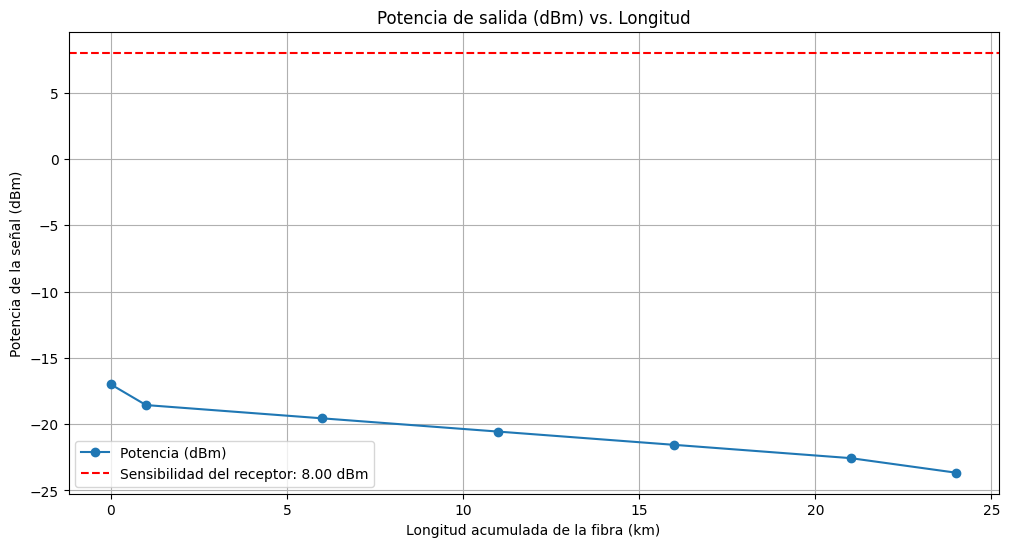

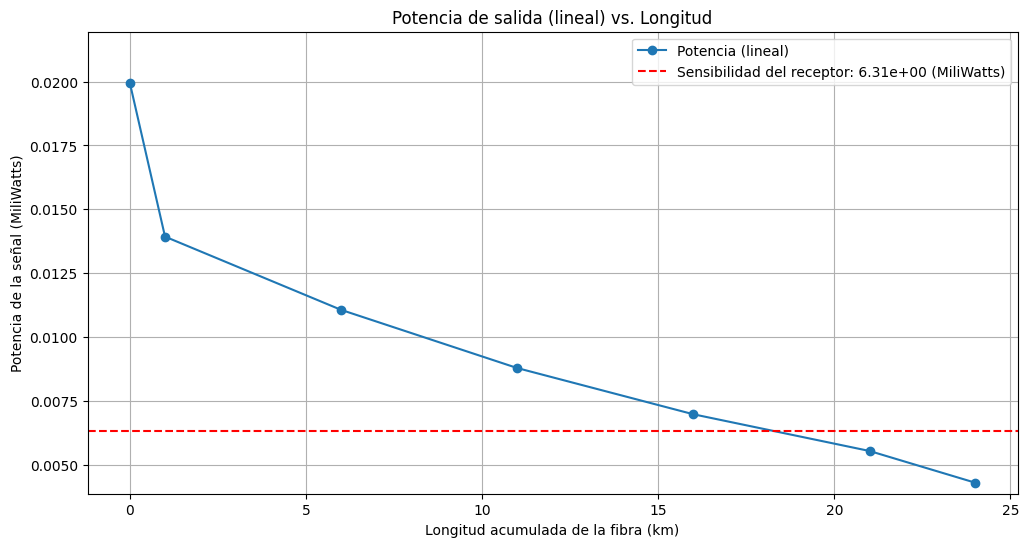

In [2]:
# Parámetros del transmisor
# Solicitar la potencia de entrada al usuario
while True:
    power_unit = input("Introduce la unidad de la potencia de entrada (dBm o MW): ").lower()
    if power_unit == 'dbm':
        tx_power_dbm = float(input("Introduce la potencia de entrada (dBm): "))
        tx_power_watts = dbm2watt(tx_power_dbm) * 1000  # Convertir a mW para GNPy
        break
    elif power_unit == 'mw':
        tx_power_watts_input = float(input("Introduce la potencia de entrada (MW): "))
        tx_power_watts = tx_power_watts_input * 1000 # Convertir a mW para GNPy
        tx_power_dbm = watt2dbm(tx_power_watts_input / 1000) # Convertir a dBm para el historial
        break
    else:
        print("Unidad no válida. Por favor, introduce 'dBm' o 'MW'.")

# Parámetros del receptor
sensibilidad_receptor_dbm = float(input("Introduce la sensibilidad del receptor en dBm: "))

# Parámetros de la simulación (no se pueden cambiar)
f_min = 191.4e12
f_max = 195.1e12
spacing = 50e9
roll_off = 0.15
tx_osnr = 40
baud_rate = 32e9
delta_pdb = 0
slot_width = spacing


# Solicitar el número de tramos de fibra
while True:
    num_tramos = int(input("Introduce el número de tramos de fibra (máximo 4): "))
    if 1 <= num_tramos <= 4:
        break
    else:
        print("Por favor, introduce un número entre 1 y 4.")

# Lista para almacenar los parámetros de cada tramo de fibra
fiber_params_per_tramo = []

for i in range(num_tramos):
    print(f"\n--- Parámetros para el Tramo de Fibra {i+1} ---")
    length = float(input(f"Introduce la longitud del tramo de fibra {i+1} (km): "))
    loss_coef = float(input(f"Introduce el coeficiente de pérdida (loss_coef) para el tramo {i+1} (dB/km): "))
    att_in = float(input(f"Introduce la atenuación de entrada (att_in) para el tramo {i+1} (dB): "))
    con_in = float(input(f"Introduce la pérdida del conector de entrada (con_in) para el tramo {i+1} (dB): "))
    con_out = float(input(f"Introduce la pérdida del conector de salida (con_out) para el tramo {i+1} (dB): "))

    fiber_params_per_tramo.append({
        'length': length,
        'loss_coef': loss_coef,
        'att_in': att_in,
        'con_in': con_in,
        'con_out': con_out,
        'effective_area': 280e-12 # Este parámetro se mantiene fijo
    })

# Revisando tu función personalizada create_input_spectral_information
def create_input_spectral_information_custom(f_min, f_max, roll_off, baud_rate, spacing, tx_osnr, tx_power,
                                             delta_pdb=0):
    """Crea una información espectral de ancho de ranura fijo con potencia plana.
    Todos los argumentos son valores escalares."""
    number_of_channels = automatic_nch(f_min, f_max, spacing)
    frequency = [(f_min + spacing * i) for i in range(number_of_channels)]
    delta_pdb_per_channel = np.ones(number_of_channels) * delta_pdb
    label = [f'{baud_rate * 1e-9 :.2f}G' for i in range(number_of_channels)]
    return create_arbitrary_spectral_information(frequency, slot_width=spacing, signal=tx_power,
                                                 baud_rate=baud_rate,
                                                 roll_off=roll_off, delta_pdb_per_channel=delta_pdb_per_channel,
                                                 tx_osnr=tx_osnr, tx_power=watt2dbm(tx_power / 1000), label=label) # GNPy espera tx_power en dBm

# Crear el objeto SpectralInformation usando la función personalizada
si = create_input_spectral_information_custom(
    f_min=f_min,
    f_max=f_max,
    roll_off=roll_off,
    baud_rate=baud_rate,
    spacing=spacing,
    tx_osnr=tx_osnr,
    tx_power=tx_power_watts # Usar la potencia en mW para la creación de SI
)
si.signal = si.signal.astype(np.float64)

power_history_dbm = [tx_power_dbm]  # Inicializar con la potencia de transmisión en dBm
power_history_linear = [db2lin(tx_power_dbm)] # Almacenar en Watts
longitud_acumulada = [0]
current_power_dbm = tx_power_dbm # Inicializar la potencia actual con la potencia de transmisión en dBm
print(f"Potencia de la señal inicial (dBm): {tx_power_dbm:.2f}")

for i, fiber_params in enumerate(fiber_params_per_tramo):
    longitud_tramo = fiber_params['length']
    loss_coef = fiber_params['loss_coef']
    att_in = fiber_params['att_in']
    con_in = fiber_params['con_in']
    con_out = fiber_params['con_out']

    potencia_inicio_tramo_para_calculo_atenuacion = current_power_dbm

    # Aplicar atenuación de entrada y conector de entrada al inicio de cada tramo (incluido el primero)
    # Se agrega con_in incluso en el primer tramo si se define
    current_power_dbm -= att_in
    current_power_dbm -= con_in # Pérdida del conector de entrada al inicio del tramo
    power_history_dbm.append(current_power_dbm)
    power_history_linear.append(db2lin(current_power_dbm))
    longitud_acumulada.append(longitud_acumulada[-1])

    # Esta será la potencia real al inicio de la fibra de cada tramo (después de sus conectores/atenuaciones iniciales)
    potencia_antes_propagacion_fibra = current_power_dbm

    num_segmentos = int(np.ceil(longitud_tramo / 5)) # Segmentos de 5 km
    for j in range(num_segmentos):
        segment_length = min(5, longitud_tramo - j * 5)
        attenuation_segment_db = loss_coef * segment_length
        current_power_dbm -= attenuation_segment_db
        power_history_dbm.append(current_power_dbm)
        power_history_linear.append(db2lin(current_power_dbm))
        longitud_acumulada.append(longitud_acumulada[-1] + segment_length)

    # Aplicar pérdidas de conector de salida al final del tramo
    current_power_dbm -= con_out
    power_history_dbm.append(current_power_dbm)
    power_history_linear.append(db2lin(current_power_dbm))
    longitud_acumulada.append(longitud_acumulada[-1]) # No hay cambio en longitud por pérdida de conector

    # Calcular la atenuación total de este tramo
    atenuacion_tramo = potencia_inicio_tramo_para_calculo_atenuacion - current_power_dbm
    print(f"Tramo {i+1}: Longitud acumulada = {longitud_acumulada[-1]:.2f} km, Potencia final = {current_power_dbm:.2f} dBm, Atenuación = {atenuacion_tramo:.2f} dB\n")

# Calcular la atenuación total real basada en la simulación
attenuation_total_simulated = tx_power_dbm - power_history_dbm[-1]

# Resultados finales
print("\nResultados Finales (basado en la simulación):")
print(f"Potencia de la señal inicial (dBm): {tx_power_dbm:.2f}")
print(f"Potencia de la señal recibida (dBm): {power_history_dbm[-1]:.2f}")
print(f"Potencia de la señal recibida (mW): {db2lin(power_history_dbm[-1]):.2f}")
print(f"Atenuación total simulada (dB): {attenuation_total_simulated:.2f}")
print(f"Sensibilidad del receptor (dBm): {sensibilidad_receptor_dbm:.2f}")

# Verificar la sensibilidad y mostrar la advertencia
if power_history_dbm[-1] < sensibilidad_receptor_dbm:
    print(f"\nAdvertencia: La potencia de la señal recibida ({power_history_dbm[-1]:.2f} dBm) "
          f"es menor que la sensibilidad del receptor ({sensibilidad_receptor_dbm:.2f} dBm).")

# Plot de la potencia en dBm vs. Longitud
x_dbm_unique = sorted(list(set([round(l, 2) for l in longitud_acumulada])))
y_dbm_unique = []
for length in x_dbm_unique:
    indices = [i for i, l in enumerate([round(val, 2) for val in longitud_acumulada]) if l == length]
    y_dbm_unique.append(power_history_dbm[indices[-1]])

plt.figure(figsize=(12, 6))
plt.plot(x_dbm_unique, y_dbm_unique, marker='o', linestyle='-', label="Potencia (dBm)")
plt.xlabel("Longitud acumulada de la fibra (km)")
plt.ylabel("Potencia de la señal (dBm)")
plt.title("Potencia de salida (dBm) vs. Longitud")
plt.grid(True)
plt.xticks(np.arange(0, max(x_dbm_unique) + 5, 5))
plt.axhline(sensibilidad_receptor_dbm, color='r', linestyle='--', label=f'Sensibilidad del receptor: {sensibilidad_receptor_dbm:.2f} dBm')
plt.legend()
plt.show()

# Plot de la potencia lineal vs. Longitud
x_linear_unique = sorted(list(set([round(l, 2) for l in longitud_acumulada])))
y_linear_unique = []
for length in x_linear_unique:
    indices = [i for i, l in enumerate([round(val, 2) for val in longitud_acumulada]) if l == length]
    y_linear_unique.append(power_history_linear[indices[-1]])

plt.figure(figsize=(12, 6))
plt.plot(x_linear_unique, y_linear_unique, marker='o', linestyle='-', label="Potencia (lineal)")
plt.xlabel("Longitud acumulada de la fibra (km)")
plt.ylabel("Potencia de la señal (MiliWatts)")
plt.title("Potencia de salida (lineal) vs. Longitud")
plt.grid(True)
plt.xticks(np.arange(0, max(x_linear_unique) + 5, 5))
sensibilidad_lineal_watts = db2lin(sensibilidad_receptor_dbm)
plt.axhline(sensibilidad_lineal_watts/1000, color='r', linestyle='--', label=f'Sensibilidad del receptor: {sensibilidad_lineal_watts:.2e} (MiliWatts)')
plt.ylim(min(y_linear_unique) * 0.9, max(y_linear_unique) * 1.1)
plt.legend()
plt.show()